# Buy and Hold Strategy

This notebook demonstrates a simple buy-and-hold strategy with comprehensive analysis:
- Configure any stock or ETF symbol (SPY, AAPL, MSFT, etc.)
- Buy on the first trading day and hold until the end
- Track performance over time
- Generate detailed pyfolio tearsheet with risk metrics

## Setup

In [13]:
# Register Sharadar bundle (required for Jupyter notebooks)
from zipline.data.bundles import register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle

register('sharadar', sharadar_bundle(tickers=None, incremental=True, include_funds=True))
print("✓ Sharadar bundle registered")

✓ Sharadar bundle registered


In [14]:
import logging
import pandas as pd
import matplotlib.pyplot as plt

from zipline import run_algorithm
from zipline.api import (
    order,
    order_target_percent,
    symbol,
    record,
    schedule_function,
    date_rules,
    time_rules,
)
from zipline.utils.progress import enable_progress_logging
from zipline.utils.flightlog_client import enable_flightlog

# Enable logging
logging.basicConfig(level=logging.INFO, force=True)

# Connect to FlightLog (optional - remove if not using)
# enable_flightlog(host='flightlog', port=9020)

# Enable progress tracking
enable_progress_logging(algo_name='Buy-and-Hold', update_interval=10)

## Configuration

Change the symbol below to backtest different stocks or ETFs.

In [15]:
# CONFIGURATION: Change the symbol to backtest different stocks
# Examples: 'SPY', 'AAPL', 'MSFT', 'QQQ', 'NVDA', 'TSLA'
SYMBOL = 'SPY'

print(f"✓ Symbol configured: {SYMBOL}")

✓ Symbol configured: SPY


## Strategy Implementation

Buy the selected stock on the first day and hold until the end.

In [16]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    # Set the stock to trade (use the configured SYMBOL)
    context.asset = symbol(SYMBOL)
    
    # Track if we've made our initial purchase
    context.has_bought = False
    
    logging.info(f"Strategy initialized. Trading: {context.asset.symbol}")


def handle_data(context, data):
    """
    Called every day (or bar).
    """
    # Buy on the first day (only if tradeable)
    if not context.has_bought and data.can_trade(context.asset):
        # Get current price
        price = data.current(context.asset, 'price')
        
        # Invest 100% of portfolio in the asset
        order_target_percent(context.asset, 1.0)
        
        context.has_bought = True
        logging.info(f"Bought {context.asset.symbol} at ${price:.2f}")
    
    # Record daily values (only if we have data)
    # IMPORTANT: Record cash for pyfolio position analysis
    if data.can_trade(context.asset):
        record(
            price=data.current(context.asset, 'price'),
            portfolio_value=context.portfolio.portfolio_value,
            cash=context.portfolio.cash
        )
    else:
        record(
            portfolio_value=context.portfolio.portfolio_value,
            cash=context.portfolio.cash
        )


def analyze(context, perf):
    """
    Called after the backtest completes.
    """
    logging.info("\n" + "="*60)
    logging.info("BACKTEST RESULTS")
    logging.info("="*60)
    
    # Calculate returns
    start_value = perf['portfolio_value'].iloc[0]
    end_value = perf['portfolio_value'].iloc[-1]
    total_return = (end_value - start_value) / start_value * 100
    
    logging.info(f"Start date: {perf.index[0].date()}")
    logging.info(f"End date: {perf.index[-1].date()}")
    logging.info(f"")
    logging.info(f"Starting portfolio value: ${start_value:,.2f}")
    logging.info(f"Ending portfolio value: ${end_value:,.2f}")
    logging.info(f"Total return: {total_return:.2f}%")
    logging.info(f"")
    logging.info(f"Number of transactions: {len(perf[perf['transactions'].apply(len) > 0])}")
    logging.info("="*60)

## Run Backtest

Run the strategy from 2020 to 2023.

In [17]:
# Run the backtest
results = run_algorithm(
    start=pd.Timestamp('2020-01-01'),
    end=pd.Timestamp('2025-11-28'),
    initialize=initialize,
    handle_data=handle_data,
    analyze=analyze,
    capital_base=100000,  # Start with $100,000
    data_frequency='daily',
    bundle='sharadar',
)

2025-11-30 06:30:14,126 INFO zipline.progress: [Buy-and-Hold] Backtest initialized: 2020-01-02 to 2025-11-28 (1486 trading days)
2025-11-30 06:30:14,126 INFO zipline.progress: [Buy-and-Hold] Progress      Pct    Date             Cum Returns        Sharpe      Max DD             Cum PNL


INFO:root:Strategy initialized. Trading: SPY
INFO:root:Bought SPY at $298.39


2025-11-30 06:30:14,635 INFO zipline.progress: [Buy-and-Hold] ----------      0%  2020-01-15              2%          7.25         -0%               $1.7K
2025-11-30 06:30:14,639 INFO zipline.progress: [Buy-and-Hold] ----------      1%  2020-01-30              2%          2.12         -3%               $1.6K
2025-11-30 06:30:14,642 INFO zipline.progress: [Buy-and-Hold] ----------      2%  2020-02-13              4%          3.26         -3%               $4.5K
2025-11-30 06:30:14,647 INFO zipline.progress: [Buy-and-Hold] ----------      2%  2020-02-28             -8%         -2.71        -12%              $-8.1K
2025-11-30 06:30:14,651 INFO zipline.progress: [Buy-and-Hold] ----------      3%  2020-03-13            -16%         -1.81        -26%             $-16.4K
2025-11-30 06:30:14,656 INFO zipline.progress: [Buy-and-Hold] ----------      4%  2020-03-27            -21%         -1.52        -33%             $-20.8K
2025-11-30 06:30:14,661 INFO zipline.progress: [Buy-and-Hold] --------

INFO:zipline.finance.metrics.tracker:Simulated 1486 trading days
 first open: 2020-01-02 14:30:00+00:00
 last close: 2025-11-28 18:00:00+00:00


2025-11-30 06:30:15,344 INFO zipline.progress: 
[Buy-and-Hold] ==================================================
2025-11-30 06:30:15,345 INFO zipline.progress: [Buy-and-Hold] Backtest Complete!
2025-11-30 06:30:15,345 INFO zipline.progress: [Buy-and-Hold] ==================================================
2025-11-30 06:30:15,345 INFO zipline.progress: [Buy-and-Hold] Trading Days:     1486
2025-11-30 06:30:15,345 INFO zipline.progress: [Buy-and-Hold] Total Return:     +129.68%
2025-11-30 06:30:15,346 INFO zipline.progress: [Buy-and-Hold] Sharpe Ratio:     0.78
2025-11-30 06:30:15,346 INFO zipline.progress: [Buy-and-Hold] Max Drawdown:     -33.5%
2025-11-30 06:30:15,346 INFO zipline.progress: [Buy-and-Hold] Final Value:      $229,681
2025-11-30 06:30:15,347 INFO zipline.progress: [Buy-and-Hold] ==================================================



INFO:root:
INFO:root:BACKTEST RESULTS
INFO:root:============================================================
INFO:root:Start date: 2020-01-02
INFO:root:End date: 2025-11-28
INFO:root:
INFO:root:Starting portfolio value: $100,000.00
INFO:root:Ending portfolio value: $229,680.82
INFO:root:Total return: 129.68%
INFO:root:
INFO:root:Number of transactions: 1
INFO:root:============================================================


## Analyze Results

Plot portfolio value over time.

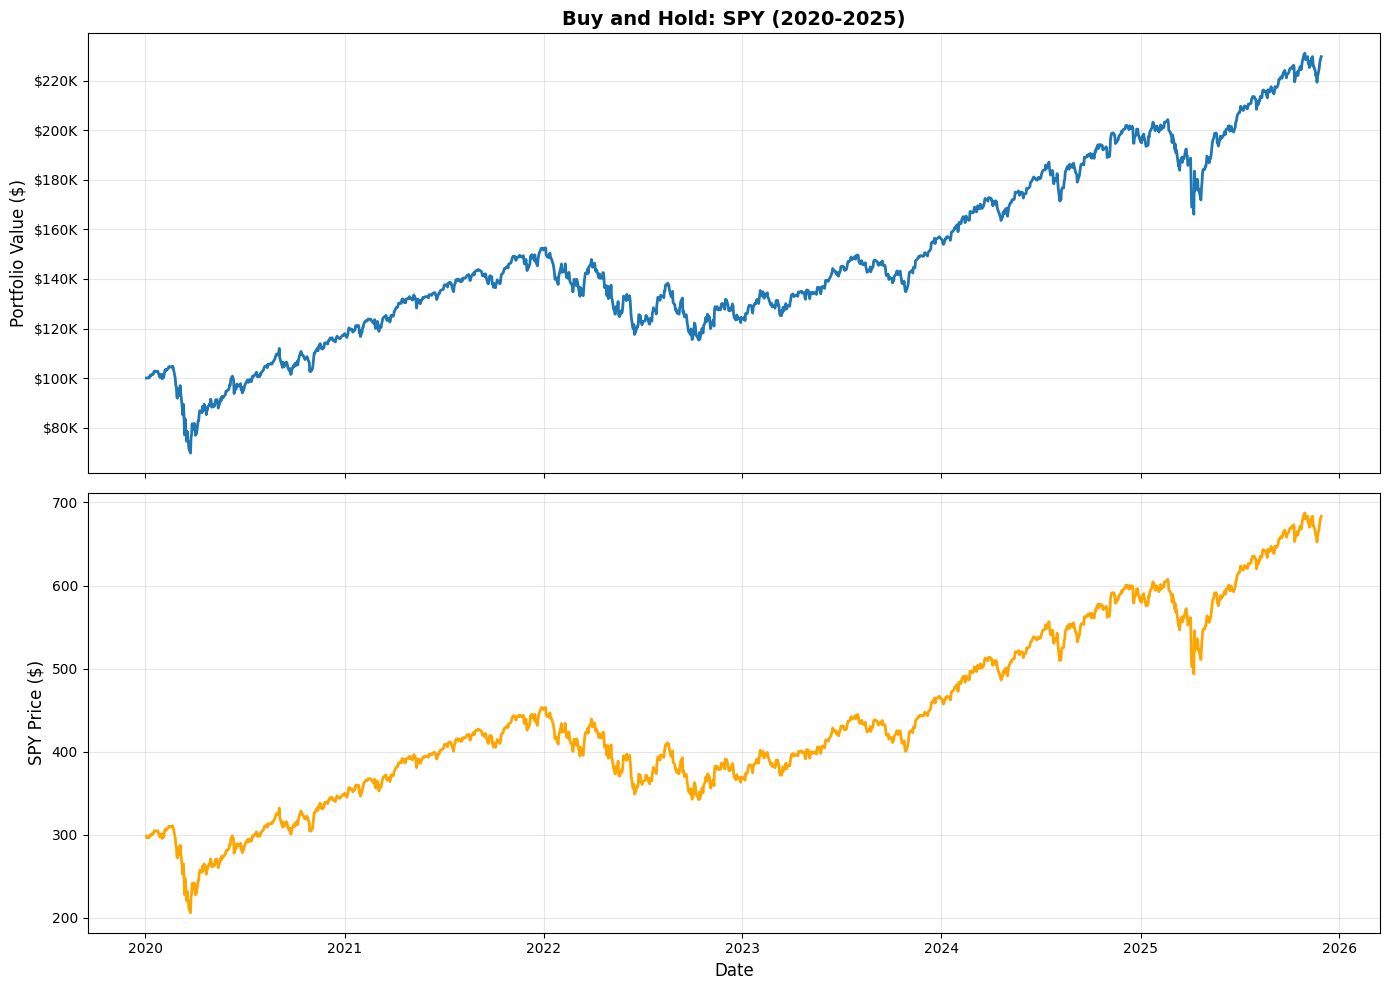


SPY - SUMMARY STATISTICS
Total Return: 129.68%
Max Portfolio Value: $231,020.82
Min Portfolio Value: $69,767.90
Final Portfolio Value: $229,680.82


In [18]:
# Plot portfolio value
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Extract date range for title
start_year = results.index[0].year
end_year = results.index[-1].year

# Portfolio value
axes[0].plot(results.index, results['portfolio_value'], linewidth=2)
axes[0].set_ylabel('Portfolio Value ($)', fontsize=12)
axes[0].set_title(f'Buy and Hold: {SYMBOL} ({start_year}-{end_year})', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Format y-axis as currency
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Asset price
axes[1].plot(results.index, results['price'], linewidth=2, color='orange')
axes[1].set_ylabel(f'{SYMBOL} Price ($)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print(f"{SYMBOL} - SUMMARY STATISTICS")
print("="*60)
print(f"Total Return: {((results['portfolio_value'].iloc[-1] / results['portfolio_value'].iloc[0]) - 1) * 100:.2f}%")
print(f"Max Portfolio Value: ${results['portfolio_value'].max():,.2f}")
print(f"Min Portfolio Value: ${results['portfolio_value'].min():,.2f}")
print(f"Final Portfolio Value: ${results['portfolio_value'].iloc[-1]:,.2f}")
print("="*60)

## View Transactions

See when trades were executed.

In [19]:
# Extract transactions
transactions = []
for date, row in results.iterrows():
    if len(row['transactions']) > 0:
        for txn in row['transactions']:
            transactions.append({
                'Date': date,
                'Symbol': txn['sid'].symbol,
                'Amount': txn['amount'],
                'Price': txn['price'],
                'Value': txn['amount'] * txn['price']
            })

if transactions:
    txn_df = pd.DataFrame(transactions)
    print("\nTransactions:")
    print(txn_df.to_string(index=False))
else:
    print("\nNo transactions executed.")


Transactions:
                     Date Symbol  Amount      Price        Value
2020-01-03 21:00:00+00:00    SPY     335 296.282067 99254.492445


## Pyfolio Analysis

Detailed performance analysis using pyfolio library.

In [20]:
# Import pyfolio and suppress matplotlib info warnings
import warnings
warnings.filterwarnings('ignore')

# Suppress matplotlib.category INFO messages (cosmetic warnings from pyfolio)
import logging
logging.getLogger('matplotlib.category').setLevel(logging.WARNING)

try:
    import pyfolio as pf
    print("✓ Pyfolio imported successfully")
except ImportError:
    print("⚠️  Pyfolio not installed. Install with: pip install pyfolio-reloaded")
    raise

✓ Pyfolio imported successfully


In [21]:
# Extract returns and positions for pyfolio
returns = results['returns']

# Extract positions (pyfolio needs DOLLAR VALUES, not share counts)
# KEY INSIGHT: row['positions'] contains ONLY stock positions, NOT cash
# Cash is stored separately in the results DataFrame
positions_data = []

for date, row in results.iterrows():
    pos_dict = {}
    
    # Get cash from results DataFrame (if available)
    if 'cash' in results.columns:
        pos_dict['cash'] = row['cash']
    
    # Iterate through ALL positions (they're all stocks, no cash in this list)
    if row['positions']:
        for pos in row['positions']:
            # Position is a dict with keys: sid, amount, cost_basis, last_sale_price
            sid = pos['sid']
            amount = pos['amount']  # number of shares
            last_sale_price = pos['last_sale_price']  # price per share
            
            # Get symbol from sid (Equity object)
            if hasattr(sid, 'symbol'):
                symbol = sid.symbol
                # Store dollar value (shares * price) for pyfolio
                pos_dict[symbol] = amount * last_sale_price
    
    if pos_dict:
        positions_data.append((date, pos_dict))

if positions_data:
    positions = pd.DataFrame([p[1] for p in positions_data],
                            index=[p[0] for p in positions_data])
    # Fill NaN values with 0 (when a position doesn't exist on certain dates)
    positions = positions.fillna(0)
else:
    positions = None

# Extract transactions
transactions_list = []
for date, row in results.iterrows():
    if row['transactions']:
        for txn in row['transactions']:
            # Transaction is a dict with sid, amount, price
            sid = txn['sid']
            symbol = sid.symbol if hasattr(sid, 'symbol') else str(sid)
            
            transactions_list.append({
                'symbol': symbol,
                'amount': txn['amount'],
                'price': txn['price'],
                'value': txn['amount'] * txn['price'],
            })

if transactions_list:
    transactions_pf = pd.DataFrame(transactions_list,
                               index=[date for date, row in results.iterrows()
                                     if row['transactions'] for _ in row['transactions']])
else:
    transactions_pf = None

print(f"✓ Data prepared for pyfolio")
print(f"  Returns: {len(returns)} days")
if positions is not None:
    print(f"  Positions: {len(positions)} days, {len(positions.columns)} assets ({', '.join(positions.columns)})")
    print(f"\n  Sample position values (first date):")
    for col in positions.columns:
        print(f"    {col}: ${positions[col].iloc[0]:,.2f}")
else:
    print(f"  Positions: None")
print(f"  Transactions: {len(transactions_pf) if transactions_pf is not None else 0} trades")

✓ Data prepared for pyfolio
  Returns: 1486 days
  Positions: 1486 days, 2 assets (cash, SPY)

  Sample position values (first date):
    cash: $100,000.00
    SPY: $0.00
  Transactions: 1 trades



PYFOLIO TEARSHEET: SPY Buy and Hold Strategy



Start date,2020-01-02
End date,2025-11-28
Total months,70
,Backtest
Annual return,15.144%
Cumulative returns,129.681%
Annual volatility,20.726%
Sharpe ratio,0.78
Calmar ratio,0.45
Stability,0.85
Max drawdown,-33.46%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.46,2020-02-19,2020-03-23,2020-08-10,123
1,24.38,2022-01-03,2022-10-12,2023-12-13,508
2,18.69,2025-02-19,2025-04-08,2025-06-26,91
3,9.37,2020-09-02,2020-09-23,2020-11-11,51
4,8.37,2024-07-16,2024-08-05,2024-09-19,48


Stress Events,mean,min,max
Covid,0.06%,-10.84%,10.45%


Top 10 long positions of all time,max
SPY,99.68%


Top 10 short positions of all time,max


Top 10 positions of all time,max
SPY,99.68%


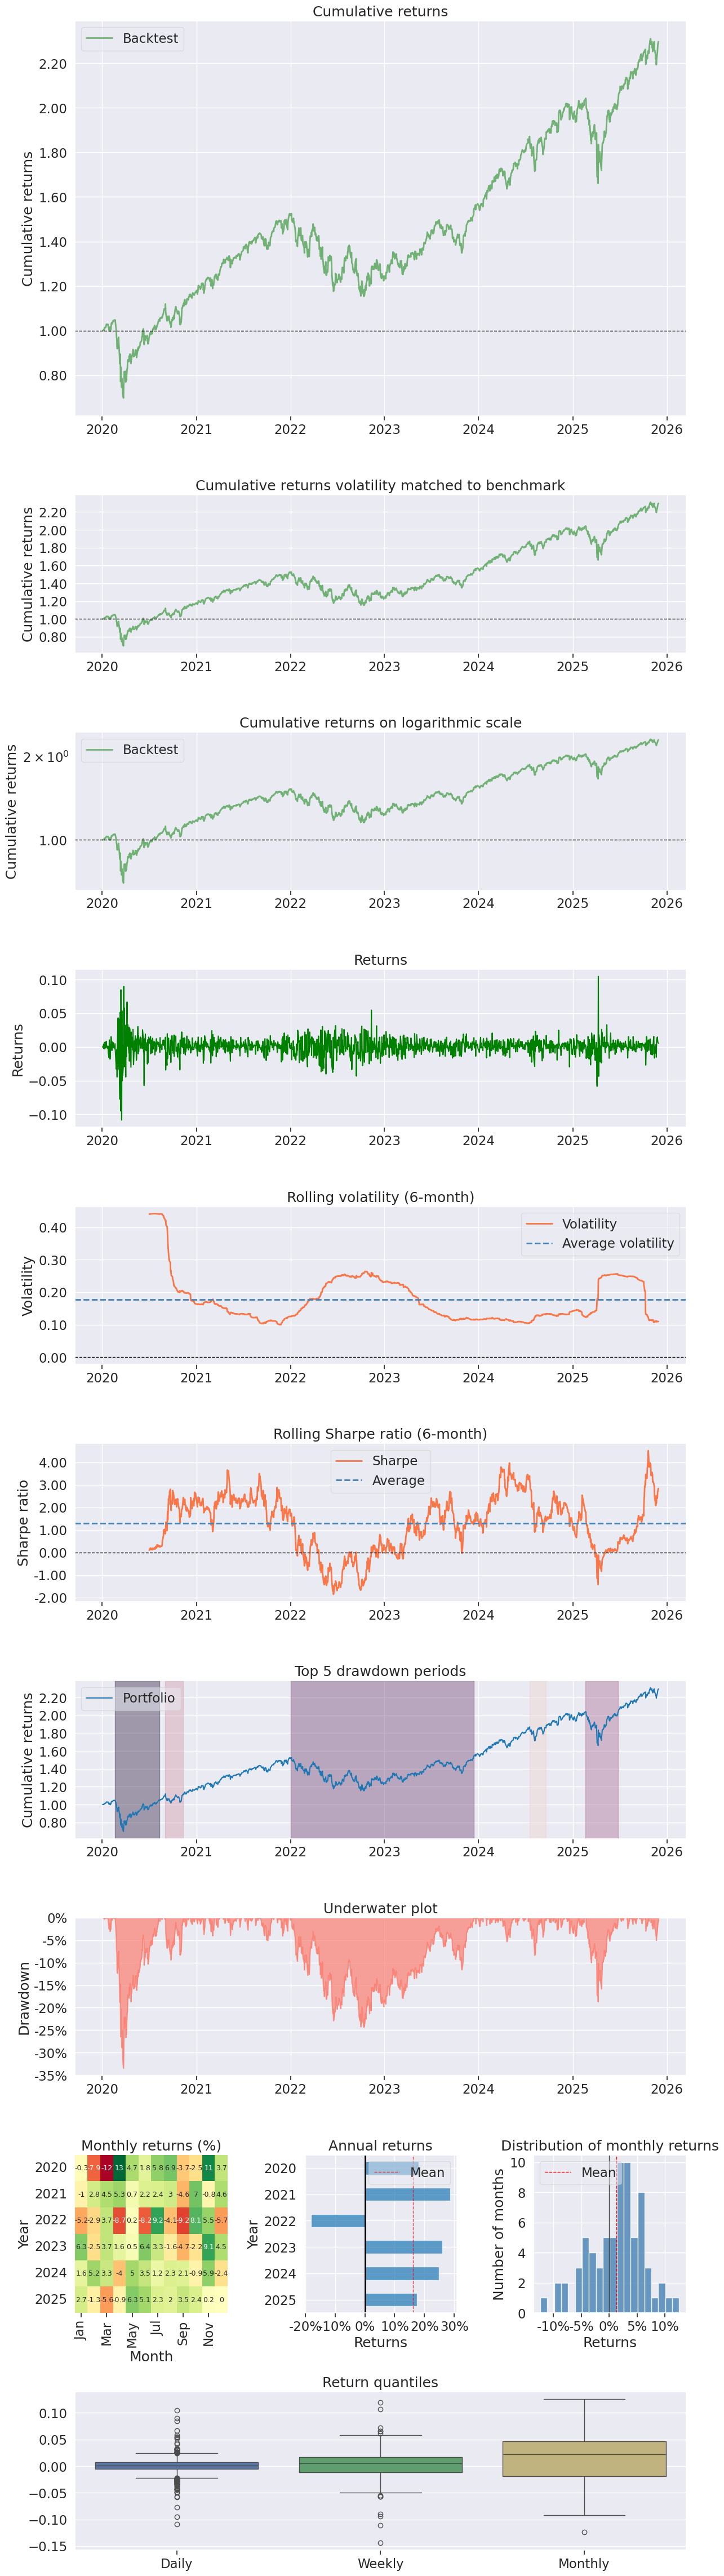

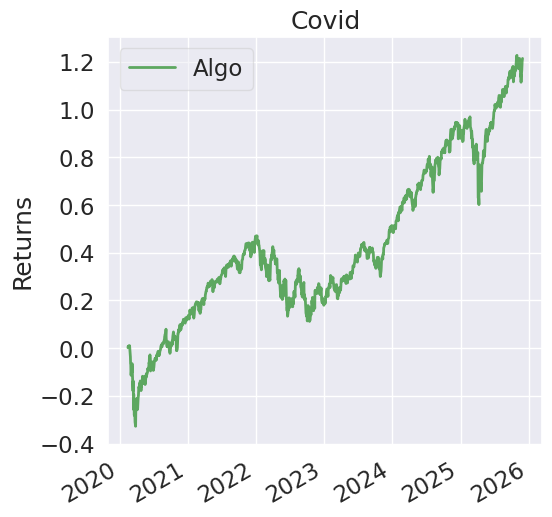

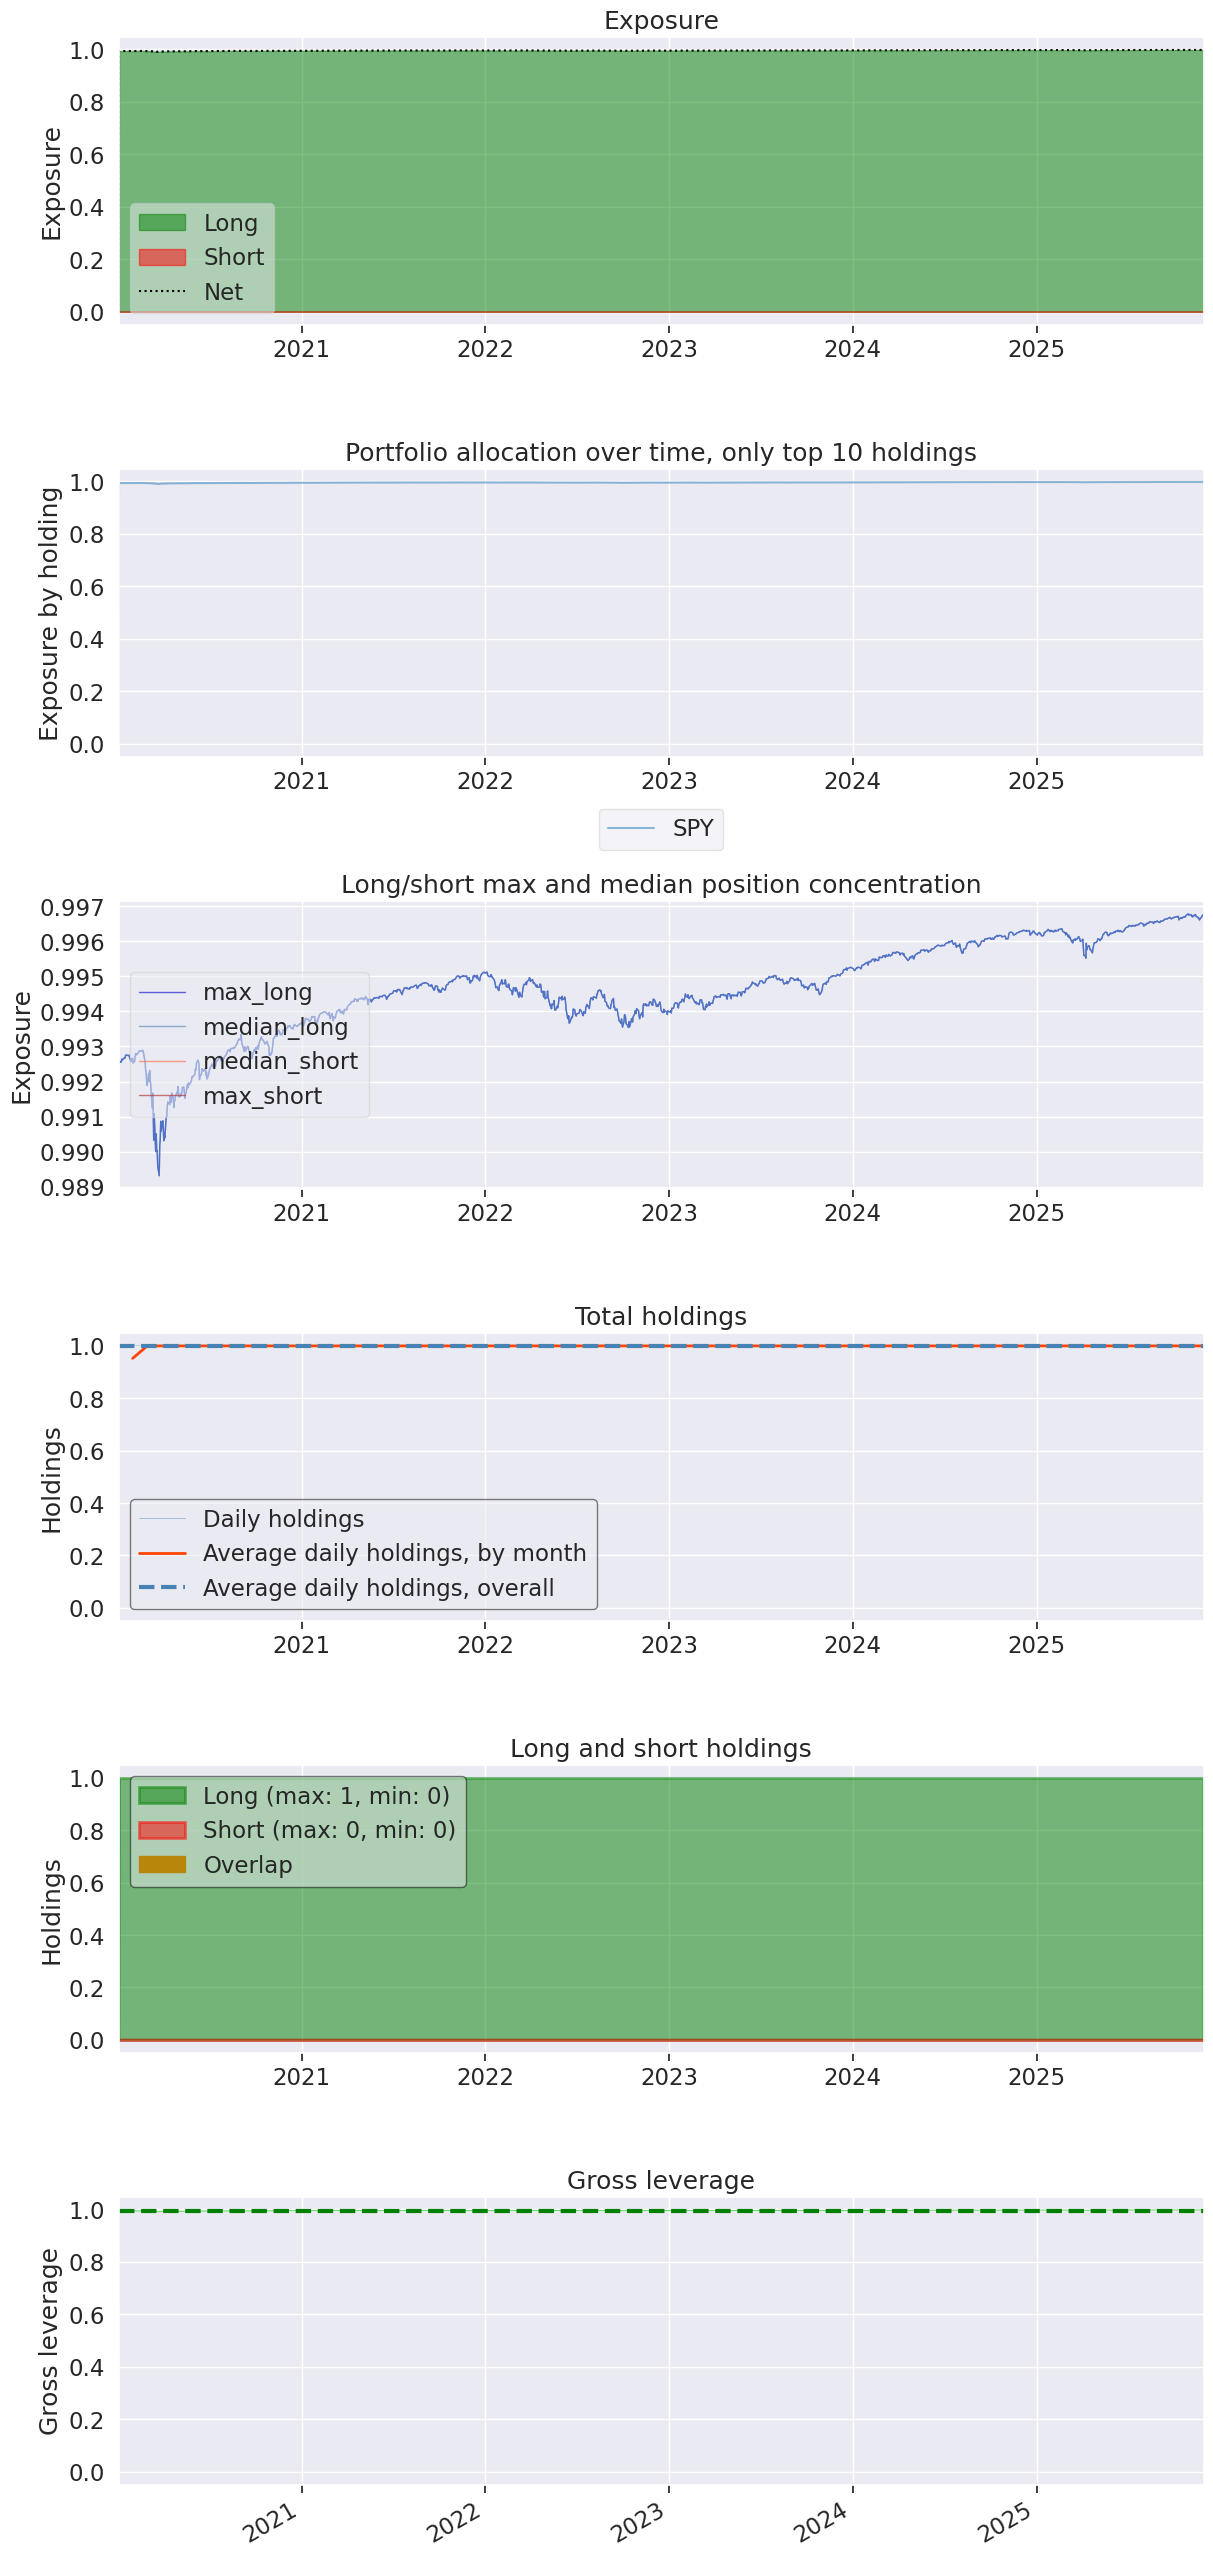

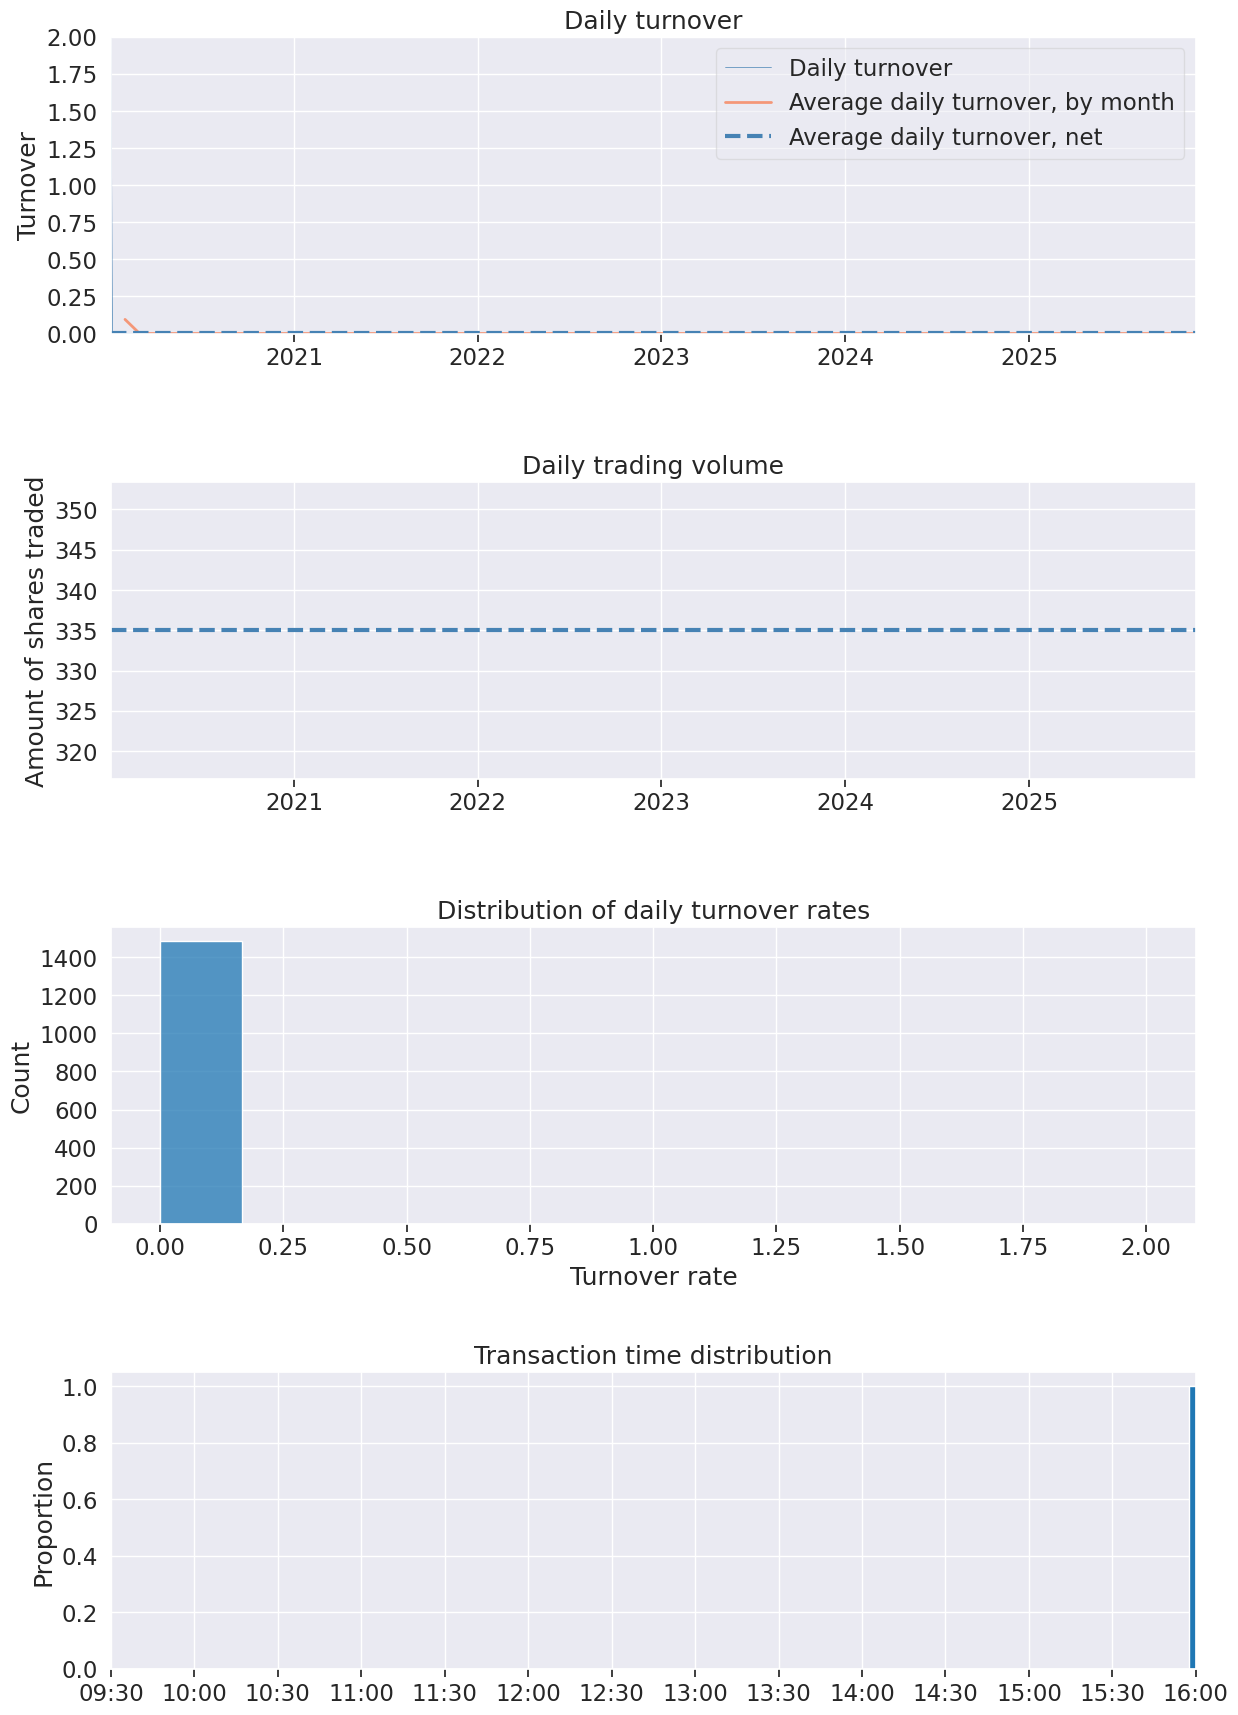

In [22]:
# Generate comprehensive tearsheet
print(f"\n{'='*60}")
print(f"PYFOLIO TEARSHEET: {SYMBOL} Buy and Hold Strategy")
print(f"{'='*60}\n")

pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions_pf,
    live_start_date=None,
    round_trips=False,
    estimate_intraday=False,  # Disable intraday detection
)

In [23]:
# Calculate and display key performance metrics
annual_return = pf.timeseries.annual_return(returns)
sharpe_ratio = pf.timeseries.sharpe_ratio(returns)
max_drawdown = pf.timeseries.max_drawdown(returns)
sortino_ratio = pf.timeseries.sortino_ratio(returns)
calmar_ratio = pf.timeseries.calmar_ratio(returns)
volatility = pf.timeseries.annual_volatility(returns)

print("\n" + "="*60)
print(f"{SYMBOL} - KEY PERFORMANCE METRICS")
print("="*60)
print(f"Annual Return: {annual_return*100:.2f}%")
print(f"Annual Volatility: {volatility*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")
print("="*60)

# Calculate cumulative returns
cum_returns = pf.timeseries.cum_returns(returns)
total_return = cum_returns.iloc[-1]
print(f"\nTotal Return: {total_return*100:.2f}%")
print(f"Final Portfolio Value: ${results['portfolio_value'].iloc[-1]:,.2f}")


SPY - KEY PERFORMANCE METRICS
Annual Return: 15.14%
Annual Volatility: 20.73%
Sharpe Ratio: 0.78
Sortino Ratio: 1.11
Calmar Ratio: 0.45
Max Drawdown: -33.46%

Total Return: 129.68%
Final Portfolio Value: $229,680.82


## Summary

This notebook demonstrates a complete buy-and-hold backtesting workflow:
- **Configurable**: Change `SYMBOL` variable to test any stock or ETF
- **Comprehensive Analysis**: Portfolio value, price charts, and transactions
- **Pyfolio Integration**: Full tearsheet with risk metrics, drawdowns, and returns analysis
- **Key Metrics**: Sharpe ratio, Sortino ratio, max drawdown, and more

## Next Steps

**To try a different symbol:**
1. Go to the "Configuration" section
2. Change `SYMBOL = 'SPY'` to your desired symbol (e.g., `'AAPL'`, `'NVDA'`)
3. Re-run all cells

**Experiment with:**
- Different time periods (modify `start` and `end` in the backtest)
- Different starting capital (modify `capital_base`)
- Compare multiple symbols by running the notebook multiple times

**Explore more strategies:**
- `03_moving_average_crossover.ipynb` - Active trading strategy
- `04_pyfolio_analysis.ipynb` - Advanced pyfolio usage
- `05_backtesting_101.ipynb` - Strategy development fundamentals